In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import re
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. User Input

## 1.1 Import and format Pareto optimal solutions

Import dataframe of objective results from pickle

In [2]:
normobjdf = pd.read_pickle("Data/normobjdf")

Create chart names for objectives 

In [3]:
obj1name = normobjdf.columns[0]
obj2name = normobjdf.columns[1]
obj3name = normobjdf.columns[2]

Import decision variable dataframe of optimisation results

In [4]:
dvdf = pd.read_pickle("Data/dvdf")

## 1.2 Import cluster numbers for visualisation

In [5]:
clusternos = pd.read_pickle('Data/clusternos')

## 1.3 Enter thresholds for brushed plots

Brushes define the objective performance scenarios of interest.

In [6]:
# Enter threshold for brushing top performing scenarios
topbrush = 0.05
# Enter threshold for brushing mid performing scenarios
upperbrush = 0.45
lowerbrush = 0.55

## 1.4 Enter shortlist category for brushing plot with shortlisted solutions.

In [7]:
shortlist = pd.read_pickle("Data/shortlist")

## 1.5 Colour maps

One colormap for clusters.

Cpool 1 and 2 are for brushing and may require editing for correct order of highlighting, which is based on what category appears first. Non-highlighted options should be a light/gray colour. 

Cpool 1 includes objective colours should preferably match those used in other figures.

In [55]:
cpool1 = ['red', 'MediumBlue', 'Green']
cpool2 = ['red']
clustcol = pd.read_pickle('Data/clustercolours')
shortcol = ['brown', 'red', 'magenta', 'yellow', 'aqua', 'Green', 
            'SteelBlue', 'Navy', 'purple', 'Black']

cmap1 = mpl.colors.ListedColormap(cpool1, 'narrowcolors')
mpl.cm.register_cmap(name = 'narrowcolormap', cmap = cmap1)

cmap2 = mpl.colors.ListedColormap(cpool2, 'onecolor')
mpl.cm.register_cmap(name = 'onecolormap', cmap = cmap2)

cmap3 = mpl.colors.ListedColormap(clustcol, 'clustcolors')
mpl.cm.register_cmap(name = 'clustcolormap', cmap = cmap3)

cmap4 = mpl.colors.ListedColormap(shortcol, 'shortcolors')
mpl.cm.register_cmap(name = 'shortcolormap', cmap = cmap4)

# 2. Functions

## 2.1 Parallel coordinates plotting function

Function to generate parallel coordinates plot and save to png file. For different categories of equal value (e.g. clusters)

Arguments:

data = dataframe to be plotted

filename = filename to save as (under Parallel Coordinates folder)

category = series that defines the category to plot to (cluster membership)

category_name = column name for category

colormap = colormap for plotting category

ylabel = y axis label

In [44]:
def parallelcoords(data, filename, category, category_name, colormap, ylabel):
    
    paralleldata = pd.DataFrame(data, copy = True)
    
    paralleldata[category_name] = category
    
    fig = plt.figure(figsize = [12,7])
    ax = fig.add_subplot(1,1,1)
    parallelcolors = mpl.cm.get_cmap(colormap)

    pd.tools.plotting.parallel_coordinates(paralleldata, category_name, lw = 2, alpha = 0.5, colormap = parallelcolors)
    
    ax.set_xticklabels(data.columns, rotation = 45, horizontalalignment = 'right')
    ax.set_yticklabels(['Best/0', 0.2, 0.4, 0.6, 0.8, 'Worst/1'])
    ax.set_ylabel(ylabel)
    ax.legend(loc = "best")

    replace_newlines = lambda s: s.replace('\n', ' ') # function to remove column newlines for filenames   
    pngfilename = 'Parallel Coordinates/%s.png' % (replace_newlines(filename))  #check/uncheck to save as png
#    epsfilename = 'Parallel Coordinates/%s.eps' % (replace_newlines(filename)) #check/uncheck to save as eps
    
    plt.savefig(pngfilename, dpi = 80, bbox_inches='tight') #check/uncheck to save as png
#    plt.savefig(epsfilename, bbox_inches = 'tight') #check/uncheck to save as eps

Function to generate parallel coordinates plot and save to png file. For brushed plots, so that non-highlighted values can be plotted in background.

Arguments:

data = dataframe to be plotted

filename = filename to save as (under Parallel Coordinates folder)

category = series that defines the category to plot to (cluster membership)

category_name = column name for category

bg_category = category that should be greyed in background

colormap = colormap for plotting category

ylabel = y axis label

In [111]:
def parallelcoordsbrush(data, filename, category, category_name, bg_category, colormap, ylabel):
    
    paralleldata = pd.DataFrame(data, copy = True)
    
    paralleldata[category_name] = category
    
    paralleldatabg = paralleldata.loc[paralleldata[category_name] == bg_category]
    paralleldatafg = paralleldata.loc[paralleldata[category_name] != bg_category]
    
    fig = plt.figure(figsize = [12,7])
    ax = fig.add_subplot(1,1,1)
    parallelcolors = mpl.cm.get_cmap(colormap)

    pd.tools.plotting.parallel_coordinates(paralleldatabg, category_name, lw = 2, alpha = 0.5, color = 'Gainsboro')
    pd.tools.plotting.parallel_coordinates(paralleldatafg, category_name, lw = 2, alpha = 0.5, colormap = parallelcolors)
    
    ax.set_xticklabels(data.columns, rotation = 45, horizontalalignment = 'right')
    ax.set_yticklabels(['Best/0', 0.2, 0.4, 0.6, 0.8, 'Worst/1'])
    ax.set_ylabel(ylabel)
    
    #set legend, with background category is last
    handles, labels = ax.get_legend_handles_labels()
    handles2 = handles[1:] + [handles[0]]
    labels2 = labels[1:] + [labels[0]]
    ax.legend(handles2, labels2, loc = 'best')
    
    replace_newlines = lambda s: s.replace('\n', ' ') # function to remove column newlines for filenames   
    pngfilename = 'Parallel Coordinates/%s.png' % (replace_newlines(filename))  #check/uncheck to save as png
#    epsfilename = 'Parallel Coordinates/%s.eps' % (replace_newlines(filename)) #check/uncheck to save as eps
    
    plt.savefig(pngfilename, dpi = 80, bbox_inches='tight') #check/uncheck to save as png
#    plt.savefig(epsfilename, bbox_inches = 'tight') #check/uncheck to save as eps

## 2.2 Brushing functions

In [40]:
# Function to create category column to 'brush' for one objective of interest less than or equal to xth percentile.
def brushlessthan(objtitle, objcattitle, data, percentile): 
        #e.g. 'Total Cost', 'Total Cost Category', dataframe, 0.05
    replace_newlines = lambda s: s.replace('\n', ' ') # function to remove column newlines objtitle 
    objcat = []
    threshold = np.percentile(data[objtitle], percentile*100)
    for i in range(0, len(data[objtitle])): 
        if (data[objtitle][i] <= threshold):
            objcat.append('Top %s%s %s' % (int(percentile*100), '%', replace_newlines(objtitle)))
        else: objcat.append('Other options')
    objcat = pd.DataFrame({objcattitle: objcat})
    return objcat

# Function to create category column to 'brush' for objectives of interest between xth and yth percentiles.
def brush(objtitle, objcattitle, data, percentileupper, percentilelower): 
        # e.g. 'Total Cost', 'Total Cost Category', dataframe, 0.45, 0.55
    replace_newlines = lambda s: s.replace('\n', ' ') # function to remove column newlines objtitle 
    objcat = []
    thresholdupper = np.percentile(data[objtitle], percentileupper*100)
    thresholdlower = np.percentile(data[objtitle], percentilelower*100)
    for i in range(0, len(data[objtitle])): 
        if (data[objtitle][i] >= thresholdupper and data[objtitle][i] <= thresholdlower):
            objcat.append('%s%s to %s%s %s' % (int(percentileupper*100), '%', 
                                               int(percentilelower*100), '%', replace_newlines(objtitle)))
        else: objcat.append('Other options')
    objcat = pd.DataFrame({objcattitle: objcat})
    return objcat

# Function to create category column to 'brush' for all 3 objectives of interest less than or equal to threshold amount.
def brushalllessthan(obj1title, obj2title, obj3title, objcattitle, data, percentile): 
    replace_newlines = lambda s: s.replace('\n', ' ') # function to remove column newlines objtitle     
    objcat = []
    thresholdobj1 = np.percentile(data[obj1title], percentile*100)
    thresholdobj2 = np.percentile(data[obj2title], percentile*100)
    thresholdobj3 = np.percentile(data[obj3title], percentile*100)
    for i in range(0, len(data[obj1title])): 
        if (data[obj1title][i] <= thresholdobj1):
            objcat.append('Top %s%s %s' % (int(percentile*100), '%', replace_newlines(obj1title)))
        elif (data[obj2title][i] <= thresholdobj2): 
            objcat.append('Top %s%s %s' % (int(percentile*100), '%', replace_newlines(obj2title)))
        elif (data[obj3title][i] <= thresholdobj3): 
            objcat.append('Top %s%s %s' % (int(percentile*100), '%', replace_newlines(obj3title)))
        else: 
            objcat.append('Other options')
    objcat = pd.DataFrame({objcattitle: objcat})
    return objcat

# 3 Execution of functions to create parallel plots

No need to change if using more than 3 objectives, otherwise add or subtract to suit

## 3.1 Plot parallel coordinates, coloured according to cluster

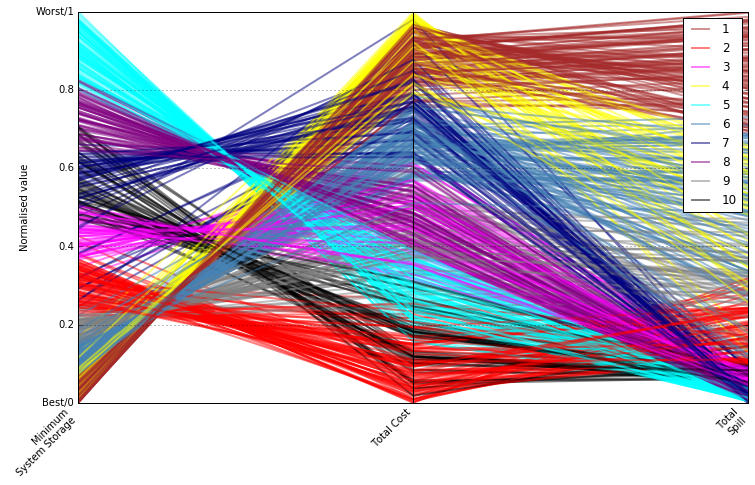

In [45]:
parallelcoords(normobjdf, 'parallelobjscluster', clusternos, 'Cluster', 'clustcolormap', 'Normalised value')

## 3.2 Plot parallel coordinates, coloured ('brushed') according to top 5% of each objective

Example: Objective 1 - Change to different objectives of interest

In [48]:
obj1cat = '%s Category' % (obj1name)
obj1topbrush = brushlessthan(obj1name, obj1cat, normobjdf, topbrush)

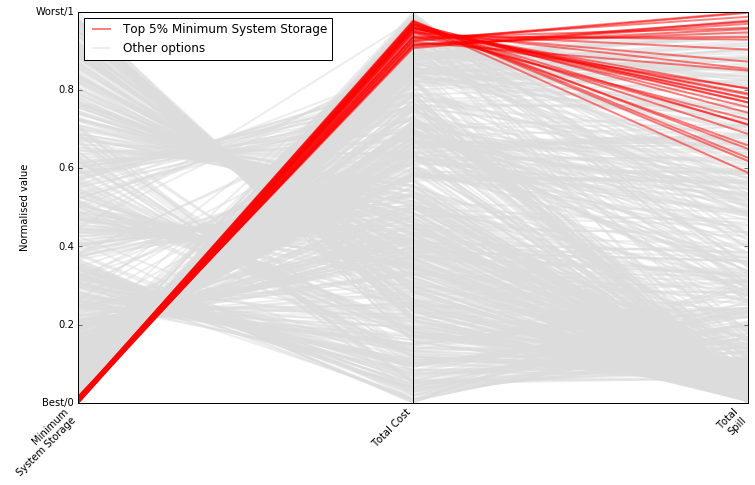

In [113]:
parallelcoordsbrush(normobjdf, 'parallelobjsbrush %s' % (obj1name), obj1topbrush, 
                    obj1cat, 'Other options', 'onecolormap', 'Normalised value')

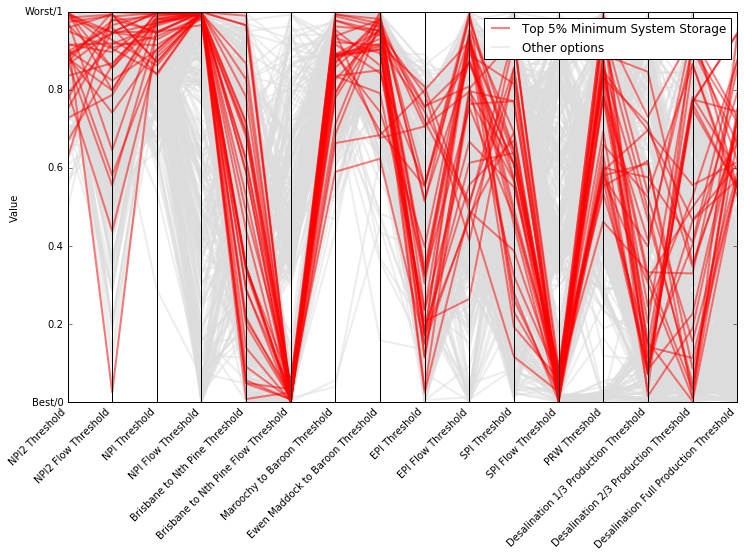

In [114]:
parallelcoordsbrush(dvdf, 'paralleldvsbrush %s' % (obj1name), obj1topbrush, 
                    obj1cat, 'Other options', 'onecolormap', 'Value')

All objectives

In [62]:
allobjcat = 'All objectives category'
allobjtopbrush = brushalllessthan(obj1name, obj2name, obj3name, allobjcat, normobjdf, topbrush)

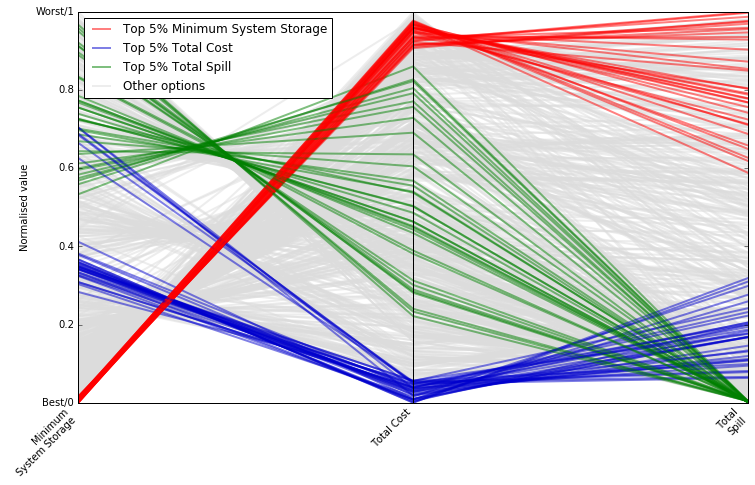

In [112]:
parallelcoordsbrush(normobjdf, 'parallelobjsbrush %s %s %s' % (obj1name, obj2name, obj3name), allobjtopbrush, 
                    allobjcat, 'Other options', 'narrowcolormap', 'Normalised value')

## 3.3 Plot parallel coordinates, coloured ('brushed') according to middle 10% of each objective

Example: Objective 1 - Change to different objectives of interest

In [116]:
obj1midbrush = brush(obj1name, obj1cat, normobjdf, upperbrush, lowerbrush)

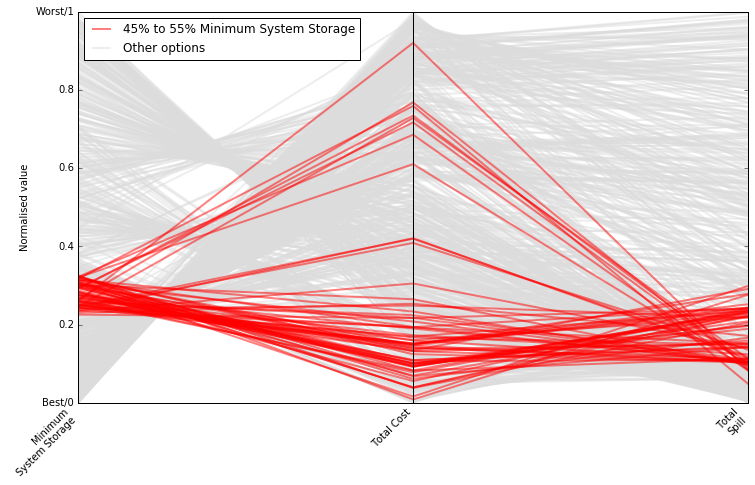

In [117]:
parallelcoordsbrush(normobjdf, 'parallelobjsmidbrush %s' % (obj1name), obj1midbrush, 
                    obj1cat, 'Other options', 'twocolormap', 'Normalised value')

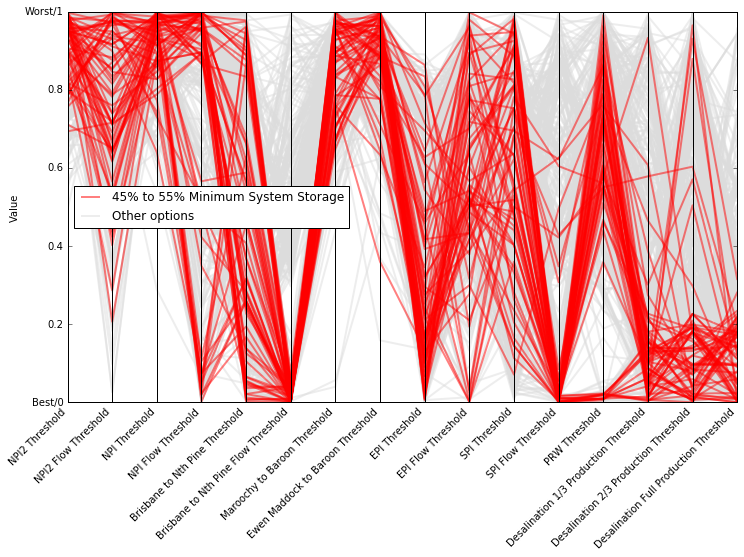

In [118]:
parallelcoordsbrush(dvdf, 'paralleldvsmidbrush %s' % (obj1name), obj1midbrush, 
                    obj1cat, 'Other options', 'twocolormap', 'Value')

## 3.4 Plot parallel coordinates, coloured ('brushed') for shortlisted scenarios

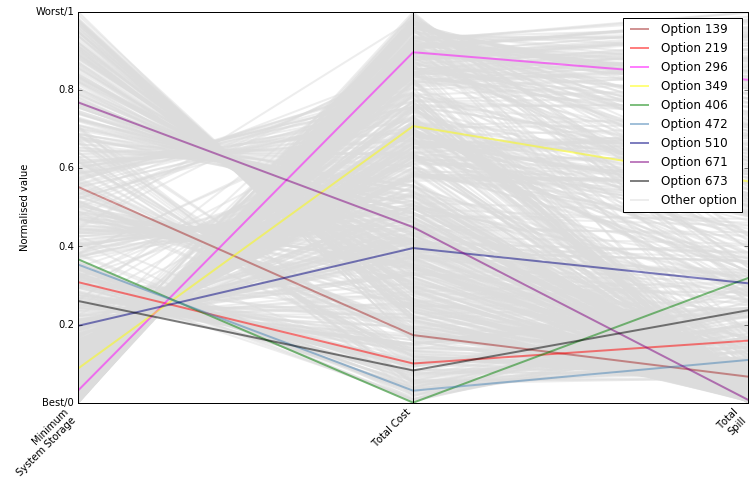

In [120]:
parallelcoordsbrush(normobjdf, 'parallelshortlistobjs', shortlist, 'Shortlist', 
                    'Other option', 'shortcolormap', 'Normalised value')

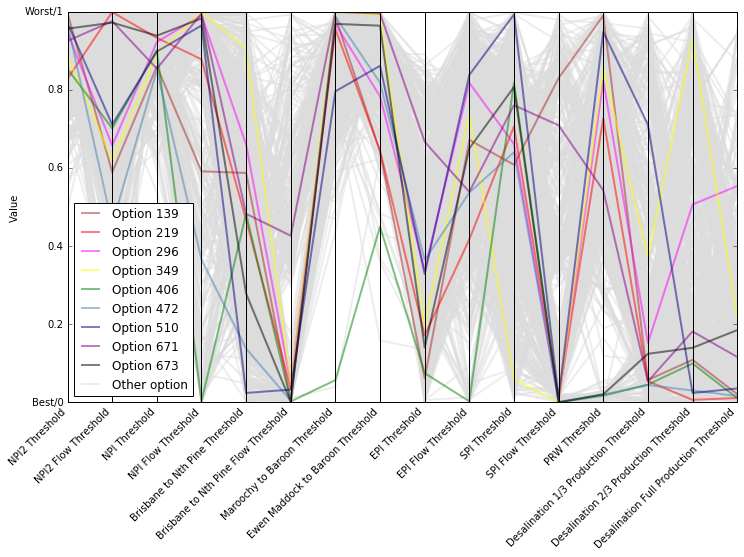

In [121]:
parallelcoordsbrush(dvdf, 'parallelshortlistdvs', shortlist, 'Shortlist', 
                    'Other option', 'shortcolormap', 'Value')